In [214]:
import os
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv
from google.cloud import bigquery
from google.oauth2 import service_account

import matplotlib.pyplot as plt

load_dotenv()

_GCP_PROJECT_ID = os.getenv('GCP_PROJECT_ID')
_BQ_DATASET_MARTS = os.getenv('BIGQUERY_DATASET_MARTS')

# BigQuery Connection

In [2]:
try:
    creds = service_account.Credentials.from_service_account_info(
        st.secrets['gcp_service_account']
    )
    client = bigquery.Client(credentials=creds, project=creds.project_id)
except Exception:
    # Local dev fallback (requires GOOGLE_APPLICATION_CREDENTIALS)
    client = bigquery.Client()

# Data Loading

In [9]:
# Get activities
query_activities = f"SELECT * FROM {_GCP_PROJECT_ID}.{_BQ_DATASET_MARTS}.fct_activities"
df_activities = client.query(query_activities).to_dataframe()

# Get activity streams
query_activits_streams = f"SELECT * FROM {_GCP_PROJECT_ID}.{_BQ_DATASET_MARTS}.fct_activity_streams"
df_activity_streams = client.query(query_activits_streams).to_dataframe()

In [25]:
print(f'Count activities: {len(df_activities)}')
print(f'Count stream pts: {len(df_activity_streams)}')

Count activities: 389
Count stream pts: 931815


# Filter relevant data

In [ ]:
# Filter
df_activities_filtered = df_activities[
    (df_activities['discipline'] == 'Run')
    & (df_activities['is_trainer'] == False)
].copy()
print(f'Len relevant activities: {len(df_activities_filtered)}')

Len relevant activities: 230


In [44]:
# Merge data
df_merged = df_activities_filtered.merge(df_activity_streams, on='activity_id', how='left', suffixes=('_x', ''))
print(f'Len relevant activity stream points: {len(df_merged)}')

Len relevant activity stream points: 725109


In [46]:
df_merged.columns

Index(['activity_id', 'athlete_id', 'gear_id', 'activity_name', 'discipline',
       'start_date_local', 'activity_date_local', 'activity_year',
       'activity_month', 'activity_weekday', 'activity_hour_local',
       'distance_m_x', 'distance_km', 'moving_time_s', 'elapsed_time_s',
       'avg_pace_min_per_km', 'avg_speed_kph', 'max_speed_kph',
       'avg_speed_overall_kph', 'elevation_gain_m', 'avg_heartrate',
       'max_heartrate', 'avg_cadence', 'energy_kj', 'avg_watts', 'max_watts',
       'weighted_watts', 'kudos_count', 'comment_count', 'achievement_count',
       'is_commute', 'is_trainer', 'has_heartrate', 'map_id', 'map_polyline',
       'mart_loaded_at_x', 'sequence_index', 'time_s', 'distance_m',
       'heartrate_bpm', 'velocity_smooth_mps', 'altitude_m', 'cadence_rpm',
       'moving', 'power_w', 'temp_c', 'grade_smooth_pct', 'lat', 'lng',
       'mart_loaded_at'],
      dtype='object')

In [394]:
df_merged[df_merged['activity_id'] == 13305253341].head()

,activity_id,athlete_id,gear_id,activity_name,discipline,start_date_local,activity_date_local,activity_year,activity_month,activity_weekday,...,velocity_smooth_mps,altitude_m,cadence_rpm,moving,power_w,temp_c,grade_smooth_pct,lat,lng,mart_loaded_at
0,13305253341,133094316,g20984891,Morning Run,Run,2025-01-09 07:17:35+00:00,2025-01-09,2025,1,5,...,0.000,98.6,0,False,0,<NA>,0.0,50.102686,8.700740,2026-01-15 17:02:59.443574+00:00
1,13305253341,133094316,g20984891,Morning Run,Run,2025-01-09 07:17:35+00:00,2025-01-09,2025,1,5,...,0.000,98.6,0,True,4,<NA>,0.0,50.102729,8.700738,2026-01-15 17:02:59.443574+00:00
2,13305253341,133094316,g20984891,Morning Run,Run,2025-01-09 07:17:35+00:00,2025-01-09,2025,1,5,...,2.900,98.6,0,True,4,<NA>,0.0,50.102729,8.700705,2026-01-15 17:02:59.443574+00:00
3,13305253341,133094316,g20984891,Morning Run,Run,2025-01-09 07:17:35+00:00,2025-01-09,2025,1,5,...,3.067,98.6,55,True,5,<NA>,-1.7,50.102754,8.700672,2026-01-15 17:02:59.443574+00:00
4,13305253341,133094316,g20984891,Morning Run,Run,2025-01-09 07:17:35+00:00,2025-01-09,2025,1,5,...,3.050,98.6,55,True,164,<NA>,-1.6,50.102764,8.700633,2026-01-15 17:02:59.443574+00:00


# Check different columns

- Decisions for the business question *"How is my training polarisation?"*

Filter:
- moving == True
- velocity > 0.5
- heartrate between 40 and 220
- cadence_rpm > 60

Columns to neglect:
- temperature -> Not relevant for this question
- altitude -> Not relevant for this question
- power -> Not correct enough -> Other values are more accurate/important

Columns to add (TODO):
- elevation_change -> Important if I run up or down -> Heartrate is highly dependent
- efficiency_index -> 


## Moving and Velocity Check

### Moving

- **Only keep data with moving == True**
- I want to analyse data where I am moving
- If moving == False, Strava thinks I am not moving
- There are 0.5% data with Moving == False and Velocity == 0 -> No movement -> This would falsify the 30sec buckets and the average pace/heartrate
- There are 1.2% data with Moving == False and Velocity > 0 -> This looks wrong -> Small amount of data -> Rather drop misleading data

### Velocity

- **Only keep data with velocity > 0.5**
- Everything below is not a realistic velocity -> too slow -> Would falsify the 30sec buckets


In [146]:
print(len(df_merged[df_merged['moving'] == True]))
print(len(df_merged[df_merged['moving'] == False]))

df_not_moving = df_merged[df_merged['moving'] == False]
print(df_not_moving.velocity_smooth_mps.value_counts())

712050
13058
velocity_smooth_mps
0.000    4036
0.060     150
0.100     121
0.080     113
0.040     103
         ... 
3.362       1
4.540       1
4.025       1
4.701       1
2.026       1
Name: count, Length: 2027, dtype: int64


Text(0.5, 1.0, 'Datapoints with moving == False')

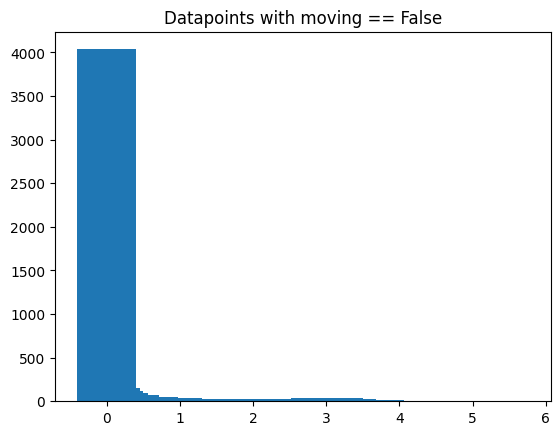

In [169]:
plt.bar(df_not_moving.velocity_smooth_mps.value_counts().index, df_not_moving.velocity_smooth_mps.value_counts().values)
plt.title('Datapoints with moving == False')

In [ ]:
df_moving = df_merged[df_merged['moving'] == True]
df_moving_velo_filtered = df_moving[df_moving['velocity_smooth_mps'] > 0.5]

print(f'Len data with too slow velocity: {len(df_moving[df_moving['velocity_smooth_mps'] <= 0.5])}')
print(f'Len data with more realistic velocity: {len(df_moving_velo_filtered)}')

Len data with too slow velocity: 759
Len data with more realistic velocity: 711291


Text(0.5, 1.0, 'Datapoints with moving == True')

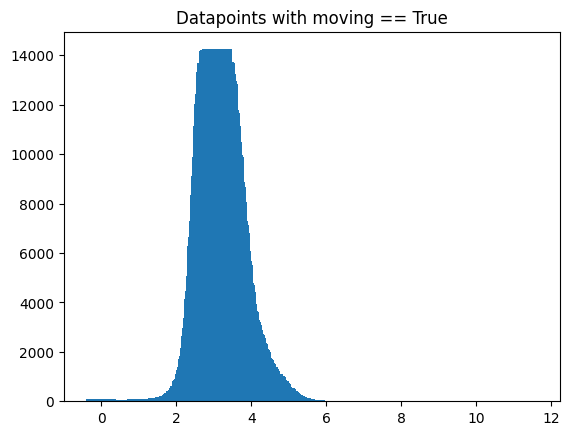

In [167]:
plt.bar(df_moving.velocity_smooth_mps.value_counts().index, df_moving.velocity_smooth_mps.value_counts().values)
plt.title('Datapoints with moving == True')

Text(0.5, 1.0, 'Datapoints with moving == True AND velocity > 0.5')

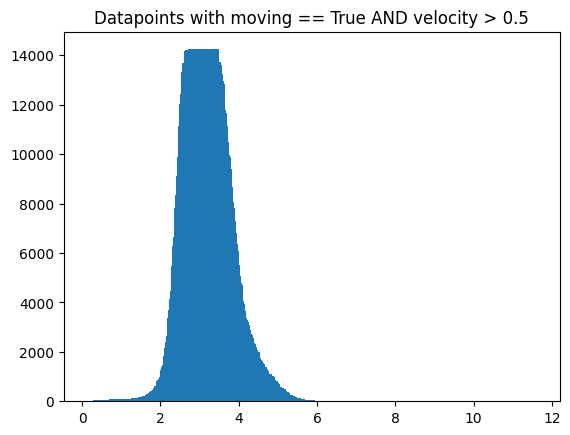

In [168]:
plt.bar(df_moving_velo_filtered.velocity_smooth_mps.value_counts().index, df_moving_velo_filtered.velocity_smooth_mps.value_counts().values)
plt.title('Datapoints with moving == True AND velocity > 0.5')

## Heartrate Check

- **Keep only heartrate values > 40 and < 220**
- Everything else is unrealistic

In [181]:
print(f'Max heartrate: {df_merged['heartrate_bpm'].max()}')
print(f'Min heartrate: {df_merged['heartrate_bpm'].min()}')
print(f'Mean heartrate: {df_merged['heartrate_bpm'].mean()}')

Max heartrate: 198
Min heartrate: 54
Mean heartrate: 143.39149321191732


<BarContainer object of 144 artists>

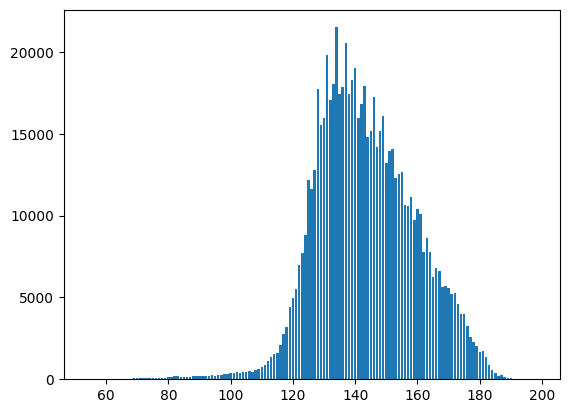

In [173]:
plt.bar(df_merged['heartrate_bpm'].value_counts().index, df_merged['heartrate_bpm'].value_counts().values)

## Cadence check

- Cadence calculates revolutions per minute -> Just on leg
- **Multiply cadence with 2 for steps per minute**

---

- Walking should be excluded from the model -> Remove data with a too low cadence -> Otherwise, this would falsify the model
- **Only keep data with cadence_rpm > 60**

In [208]:
print(f'Max cadence: {df_merged['cadence_rpm'].max()}')
print(f'Min cadence: {df_merged['cadence_rpm'].min()}')
print(f'Mean cadence: {df_merged['cadence_rpm'].mean()}')


print('-----')
print(f'Len without any  filter: {len(df_merged)}')
print(f'Len with cadence filter: {len(df_merged[df_merged['cadence_rpm'] >= 60])}')
print(f'Mean cadence after filtering: {df_merged[df_merged['cadence_rpm'] >= 60]['cadence_rpm'].mean()}')

print('-----')
print(f'Len with moving-velo filter: {len(df_moving_velo_filtered)}')
print(f'Len with moving-velo-cadence filter: {len(df_moving_velo_filtered[df_moving_velo_filtered['cadence_rpm'] > 60])}')
print(f'Mean cadence after filtering: {df_moving_velo_filtered[df_moving_velo_filtered['cadence_rpm'] >= 60]['cadence_rpm'].mean()}')

Max cadence: 118
Min cadence: 0
Mean cadence: 84.3232208167611
-----
Len without any  filter: 725109
Len with cadence filter: 712261
Mean cadence after filtering: 85.6873533718679
-----
Len with moving-velo filter: 711291
Len with moving-velo-cadence filter: 705725
Mean cadence after filtering: 85.70050772207883


Text(0.5, 1.0, 'Cadence - revolutions per minute (One leg)')

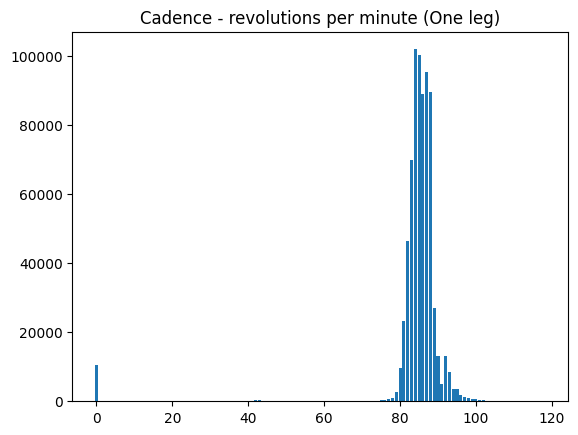

In [ ]:
# Check original data
plt.bar(df_merged['cadence_rpm'].value_counts().index, df_merged['cadence_rpm'].value_counts().values)
plt.title('Cadence - revolutions per minute (One leg)')

In [209]:
df_moving_velo_cadence_filtered = df_moving_velo_filtered[df_moving_velo_filtered['cadence_rpm'] > 60]

Text(0.5, 1.0, 'Cadence - revolutions per minute (One leg)')

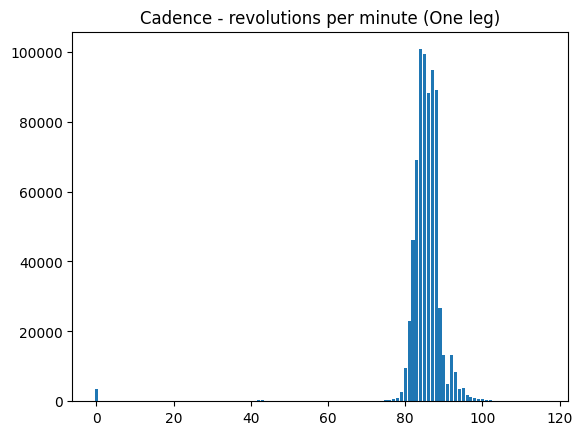

In [ ]:
# Check original data
plt.bar(df_moving_velo_filtered['cadence_rpm'].value_counts().index, df_moving_velo_filtered['cadence_rpm'].value_counts().values)
plt.title('Cadence - revolutions per minute (One leg)')

## power check

- Not meaningful enough

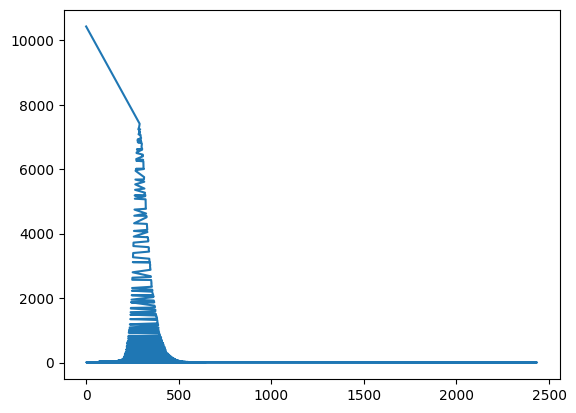

In [211]:
plt.plot(df_merged['power_w'].value_counts().index, df_merged['power_w'].value_counts().values)

<Axes: xlabel='velocity_smooth_mps', ylabel='power_w'>

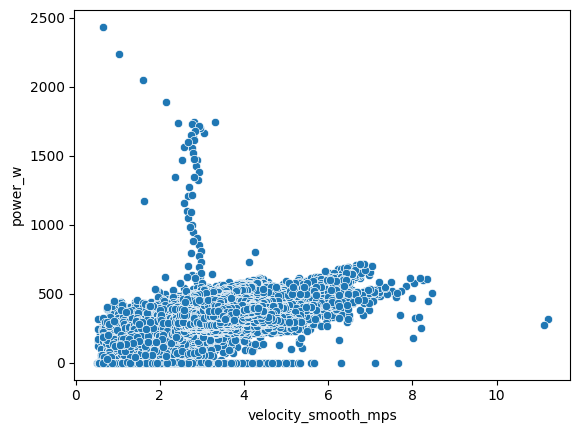

In [217]:
sns.scatterplot(x="velocity_smooth_mps", y="power_w", data=df_moving_velo_cadence_filtered)

## Check dependeny of multiple columns

In [220]:
df = df_moving_velo_cadence_filtered
print(f'Len df to analyse: {len(df)}')

df.columns

Len df to analyse: 705725


Index(['activity_id', 'athlete_id', 'gear_id', 'activity_name', 'discipline',
       'start_date_local', 'activity_date_local', 'activity_year',
       'activity_month', 'activity_weekday', 'activity_hour_local',
       'distance_m_x', 'distance_km', 'moving_time_s', 'elapsed_time_s',
       'avg_pace_min_per_km', 'avg_speed_kph', 'max_speed_kph',
       'avg_speed_overall_kph', 'elevation_gain_m', 'avg_heartrate',
       'max_heartrate', 'avg_cadence', 'energy_kj', 'avg_watts', 'max_watts',
       'weighted_watts', 'kudos_count', 'comment_count', 'achievement_count',
       'is_commute', 'is_trainer', 'has_heartrate', 'map_id', 'map_polyline',
       'mart_loaded_at_x', 'sequence_index', 'time_s', 'distance_m',
       'heartrate_bpm', 'velocity_smooth_mps', 'altitude_m', 'cadence_rpm',
       'moving', 'power_w', 'temp_c', 'grade_smooth_pct', 'lat', 'lng',
       'mart_loaded_at'],
      dtype='object')

<Axes: xlabel='distance_m', ylabel='time_s'>

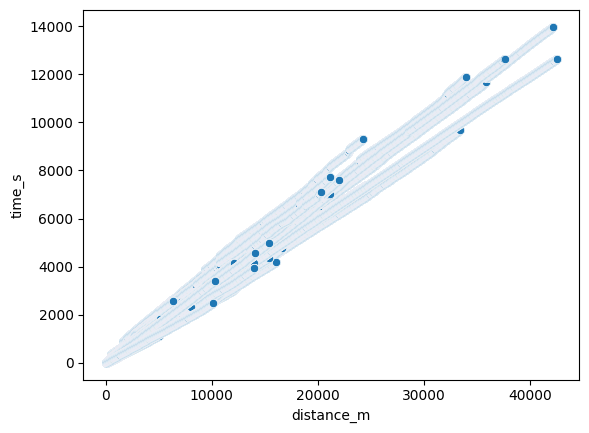

In [221]:
sns.scatterplot(x='distance_m', y='time_s', data=df)

<Axes: xlabel='distance_m', ylabel='cadence_rpm'>

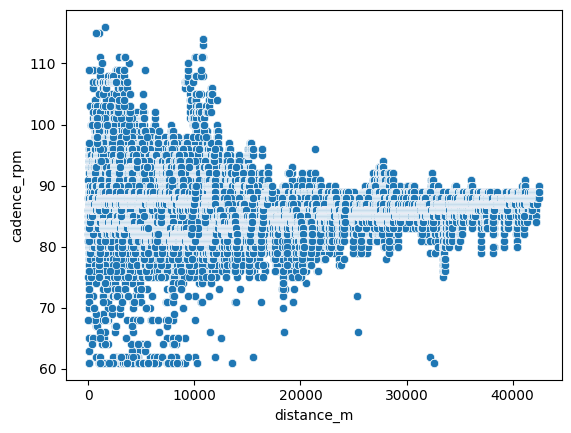

In [225]:
sns.scatterplot(x='distance_m', y='cadence_rpm', data=df)

<Axes: xlabel='distance_m', ylabel='heartrate_bpm'>

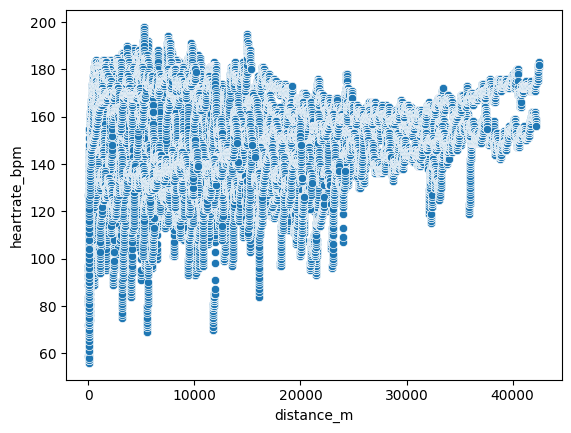

In [ ]:
sns.scatterplot(x='distance_m', y='heartrate_bpm', data=df)

<Axes: xlabel='distance_m', ylabel='velocity_smooth_mps'>

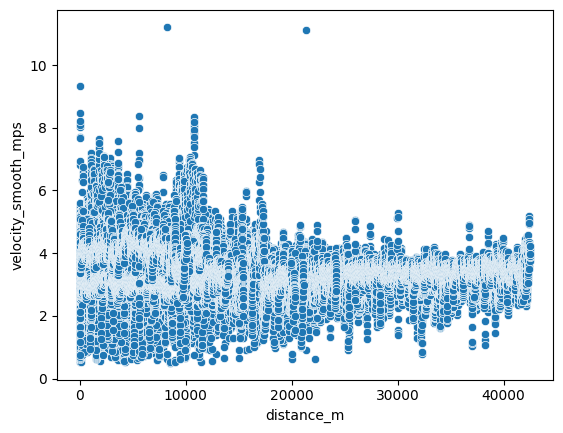

In [232]:
sns.scatterplot(x='distance_m', y='velocity_smooth_mps', data=df)

<Axes: xlabel='distance_m', ylabel='altitude_m'>

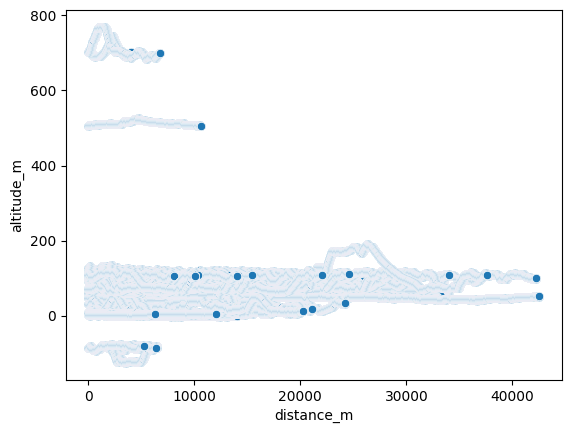

In [235]:
sns.scatterplot(x='distance_m', y='altitude_m', data=df)

<Axes: xlabel='velocity_smooth_mps', ylabel='heartrate_bpm'>

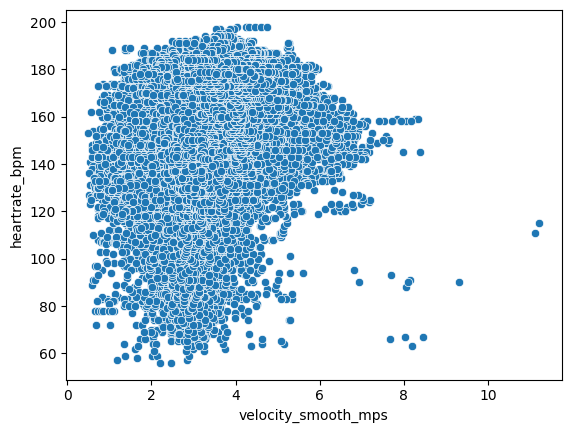

In [236]:
sns.scatterplot(x='velocity_smooth_mps', y='heartrate_bpm', data=df)

<Axes: xlabel='velocity_smooth_mps', ylabel='cadence_rpm'>

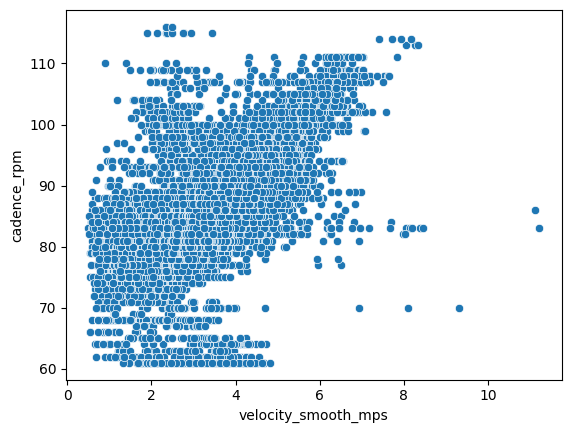

In [ ]:
sns.scatterplot(x='velocity_smooth_mps', y='cadence_rpm', data=df)

<Axes: xlabel='cadence_rpm', ylabel='heartrate_bpm'>

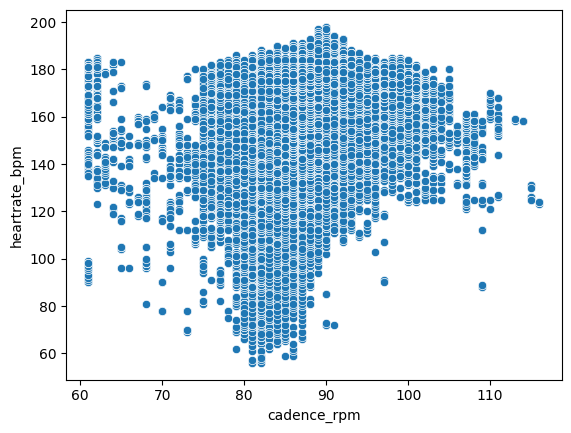

In [238]:
sns.scatterplot(x='cadence_rpm', y='heartrate_bpm', data=df)

# Preprocess data

In [281]:
# Cols that are needed to engineer the basic data model
feature_cols = [
    'activity_id',
    'start_date_local',
    'time_s',
    'distance_m',
    'moving',
    'heartrate_bpm',
    'velocity_smooth_mps',
    'altitude_m',
    'cadence_rpm',
]
df_features = df_merged[[*feature_cols]].copy()

print(f'Len df_features: {len(df_features)}')
df_features.head()

Len df_features: 725109


,activity_id,start_date_local,time_s,distance_m,moving,heartrate_bpm,velocity_smooth_mps,altitude_m,cadence_rpm
0,13305253341,2025-01-09 07:17:35+00:00,0,0.7,False,90,0.000,98.6,0
1,13305253341,2025-01-09 07:17:35+00:00,1,3.9,True,90,0.000,98.6,0
2,13305253341,2025-01-09 07:17:35+00:00,2,6.5,True,91,2.900,98.6,0
3,13305253341,2025-01-09 07:17:35+00:00,3,9.9,True,91,3.067,98.6,55
4,13305253341,2025-01-09 07:17:35+00:00,4,12.9,True,91,3.050,98.6,55


In [282]:
# Filter data
df_clean = df_features[
    (df_features['moving'] == True) & 
    (df_features['velocity_smooth_mps'] > 0.5) & 
    (df_features['heartrate_bpm'].between(40, 220)) & 
    (df_features['cadence_rpm'] > 60)
].copy()

print(f'Len df_clean: {len(df_clean)}')
df_clean.head()

Len df_clean: 702871


,activity_id,start_date_local,time_s,distance_m,moving,heartrate_bpm,velocity_smooth_mps,altitude_m,cadence_rpm
6,13305253341,2025-01-09 07:17:35+00:00,6,19.1,True,91,3.04,98.4,86
7,13305253341,2025-01-09 07:17:35+00:00,7,22.9,True,90,3.28,98.2,86
8,13305253341,2025-01-09 07:17:35+00:00,8,26.4,True,91,3.30,98.2,86
9,13305253341,2025-01-09 07:17:35+00:00,9,29.6,True,91,3.34,98.0,88
10,13305253341,2025-01-09 07:17:35+00:00,10,33.1,True,92,3.50,97.8,88


In [283]:
df_clean['bucket_index'] = df_clean['time_s'] // 30

In [284]:
# Create aggregation rules
agg_rules = {
    'heartrate_bpm': 'mean',
    'velocity_smooth_mps': 'mean',
    'cadence_rpm': 'mean',
    # Elevation Change: Last value minus first value in the bucket
    'altitude_m': lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 0 else 0,
    # Take date for future knowledge
    'start_date_local': 'first' 
}

# Create df with buckets
df_buckets = df_clean.groupby(['activity_id', 'bucket_index']).agg(agg_rules)
df_buckets = df_buckets.reset_index()

In [285]:
# Rename columns
df_buckets.rename(columns={
    'altitude_m': 'elevation_change_m',
    'velocity_smooth_mps': 'avg_speed_mps',
    'heartrate_bpm': 'avg_hr',
    'cadence_rpm': 'avg_cadence_rpm'
}, inplace=True)
df_buckets.head()

,activity_id,bucket_index,avg_hr,avg_speed_mps,avg_cadence_rpm,elevation_change_m,start_date_local
0,12692532615,0,99.7,2.875850,74.75,1.1,2024-10-19 14:00:00+00:00
1,12692532615,1,115.466667,2.607967,83.966667,1.5,2024-10-19 14:00:00+00:00
2,12692532615,2,135.448276,3.016207,83.793103,-1.3,2024-10-19 14:00:00+00:00
3,12692532615,3,154.4,3.189033,83.033333,-4.7,2024-10-19 14:00:00+00:00
4,12692532615,4,164.9,3.493967,82.666667,-2.4,2024-10-19 14:00:00+00:00


In [296]:
# Correct cadence to spm and speed to kph
df_buckets['avg_cadence_spm'] = df_buckets['avg_cadence_rpm'] * 2
df_buckets['avg_speed_kph'] = df_buckets['avg_speed_mps'] * 3.6

# Create efficieny index (Speed [m/s] / Heart Rate)
# The higher the better, the lower the more inefficient
df_buckets['efficiency_index'] = df_buckets['avg_speed_mps'] / df_buckets['avg_hr']

# Create stride length in meters
# Speed (m/s) / (Steps per second) -> Steps per second = SPM / 60
df_buckets['stride_length_m'] = df_buckets['avg_speed_mps'] / (df_buckets['avg_cadence_spm'] / 60)

In [297]:
df_buckets.head()

,activity_id,bucket_index,avg_hr,avg_speed_mps,avg_cadence_rpm,elevation_change_m,start_date_local,avg_cadence_spm,avg_speed_kph,efficiency_index,stride_length_m
0,12692532615,0,99.7,2.875850,74.75,1.1,2024-10-19 14:00:00+00:00,149.5,10.353060,0.028845,1.154187
1,12692532615,1,115.466667,2.607967,83.966667,1.5,2024-10-19 14:00:00+00:00,167.933333,9.388680,0.022586,0.931786
2,12692532615,2,135.448276,3.016207,83.793103,-1.3,2024-10-19 14:00:00+00:00,167.586207,10.858345,0.022268,1.079877
3,12692532615,3,154.4,3.189033,83.033333,-4.7,2024-10-19 14:00:00+00:00,166.066667,11.480520,0.020654,1.1522
4,12692532615,4,164.9,3.493967,82.666667,-2.4,2024-10-19 14:00:00+00:00,165.333333,12.578280,0.021188,1.267972


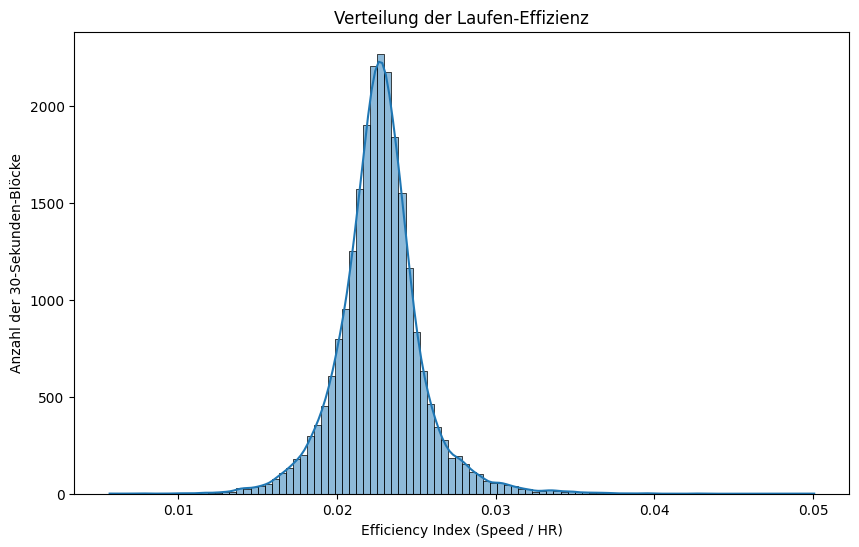

In [ ]:
# Visualize efficiency
plt.figure(figsize=(10, 6))

sns.histplot(df_buckets['efficiency_index'], bins=100, kde=True)

plt.title('Verteilung der Laufen-Effizienz')
plt.xlabel('Efficiency Index (Speed / HR)')
plt.ylabel('Anzahl der 30-Sekunden-Blöcke')
plt.show()

# Helper functions

In [ ]:
def auto_label_clusters(summary_df):
    """
    Nimmt die Cluster-Summary-Tabelle (Means) und gibt ein Dictionary 
    mit den Namen zurück: {0: 'Recovery', 1: 'Intervals', ...}
    """
    labels = {}
    
    # Wir arbeiten mit einer Kopie, damit wir Zeilen "rausstreichen" können
    remaining = summary_df.copy()
    
    # --- SCHRITT 1: TERRAIN ERKENNEN (Bergauf/Bergab) ---
    # Schwellenwert: Ab wann ist es ein Berg? (z.B. > 1.0m auf 30sek)
    # Du kannst diesen Wert anpassen. 1.0m pro 30s sind 120hm/Stunde.
    HILL_THRESHOLD = 1.0 
    DOWNHILL_THRESHOLD = -2.0 # Bergab sind wir oft schneller/extremer
    
    # 1a. Suche den Berg-Cluster (Höchste Steigung & über dem Schwellenwert)
    potential_hill = remaining['elevation_change_m'].idxmax()
    if remaining.loc[potential_hill, 'elevation_change_m'] > HILL_THRESHOLD:
        labels[potential_hill] = 'Hills / Strength'
        remaining = remaining.drop(potential_hill) # Aus dem Ranking entfernen
        
    # 1b. Suche den Downhill-Cluster (Niedrigste Steigung & unter Schwellenwert)
    if not remaining.empty:
        potential_downhill = remaining['elevation_change_m'].idxmin()
        if remaining.loc[potential_downhill, 'elevation_change_m'] < DOWNHILL_THRESHOLD:
            labels[potential_downhill] = 'Downhill / Free Speed'
            remaining = remaining.drop(potential_downhill)

    # --- SCHRITT 2: INTENSITÄT RANKING (Für die flachen Cluster) ---
    # Wir sortieren die restlichen Cluster nach Herzfrequenz (niedrig -> hoch)
    sorted_by_hr = remaining.sort_values('avg_hr').index.tolist()
    
    # Je nachdem, wie viele Cluster übrig sind, verteilen wir die Namen
    count = len(sorted_by_hr)
    
    if count == 1:
        labels[sorted_by_hr[0]] = 'Steady State'
        
    elif count == 2:
        labels[sorted_by_hr[0]] = 'Recovery / Zone 1'
        labels[sorted_by_hr[1]] = 'Tempo / Threshold'
        
    elif count == 3:
        labels[sorted_by_hr[0]] = 'Recovery / Zone 1'
        labels[sorted_by_hr[1]] = 'Zone 2 / Base'
        labels[sorted_by_hr[2]] = 'Tempo / Threshold'
        
    elif count >= 4:
        # Das ist dein aktueller Fall (mit Junk Miles Unterscheidung)
        labels[sorted_by_hr[0]] = 'Recovery / Zone 1'
        labels[sorted_by_hr[1]] = 'Zone 2 / Base'
        # Der vorletzte ist oft der "Grey Zone" Cluster
        labels[sorted_by_hr[2]] = 'Zone 3 / Junk?' 
        labels[sorted_by_hr[-1]] = 'VO2Max / Intervals'
        
    return labels

# TODO: Use LLM for Cluster assignment?!

# Clustering

In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Features auswählen
features = [
    'avg_hr', 
    'avg_speed_kph', 
    'elevation_change_m', 
    'avg_cadence_spm', 
    'efficiency_index'
]

# 2. Skalieren (Standardisieren) - WICHTIG!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_buckets[features])

# 3. Clustering (Wir suchen z.B. 5 Cluster)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_buckets['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Analyse der Cluster (Was bedeuten sie?)
summary = df_buckets.groupby('cluster')[features].mean()
summary.reset_index().sort_values('cluster')

,cluster,avg_hr,avg_speed_kph,elevation_change_m,avg_cadence_spm,efficiency_index
0,0,153.344033,12.340154,0.292633,174.103624,0.022398
1,1,130.297211,10.782597,0.044271,168.122411,0.023063
2,2,148.951496,10.086640,1.783362,167.504089,0.018883
3,3,164.037966,15.296195,-0.360184,182.789702,0.026019
4,4,134.5052,12.087482,-3.350620,170.087592,0.025081


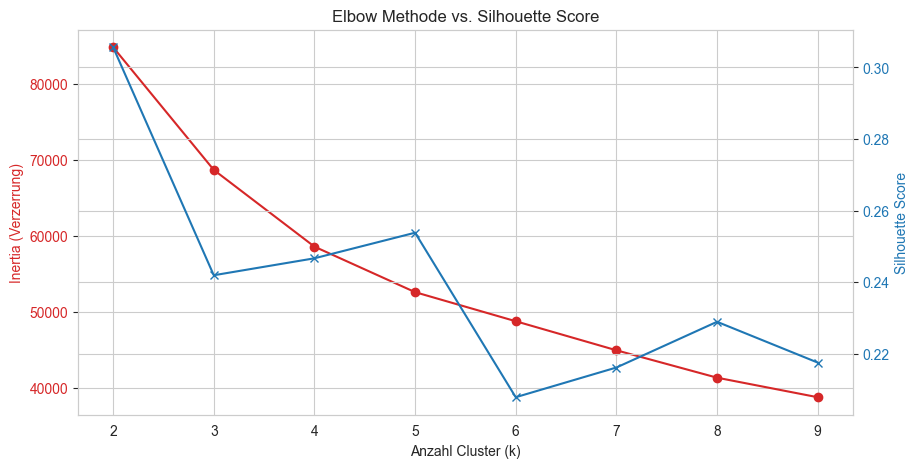

In [382]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotten
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Anzahl Cluster (k)')
ax1.set_ylabel('Inertia (Verzerrung)', color=color)
ax1.plot(K_range, inertia, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)  
ax2.plot(K_range, silhouette_scores, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Methode vs. Silhouette Score')
plt.show()

In [383]:
# 2. Generiere das Mapping
cluster_names = auto_label_clusters(summary)
# 3. Ergebnis anzeigen
# print("Automatische Zuweisung:")
# for cluster_id, name in cluster_names.items():
#     print(f"Cluster {cluster_id}: {name}")

# 4. Ins DataFrame übertragen für Plots
df_buckets['cluster_label'] = df_buckets['cluster'].map(cluster_names)

# 1. Wir gruppieren nach dem NAMEN (Label), den wir eben erstellt haben
# Wir zählen die Buckets und rechnen in Stunden um (Bucket * 30s / 3600)
polarization = df_buckets.groupby(['cluster_label', 'cluster']).size() * 30 / 3600

# 2. Wir machen daraus ein schönes DataFrame
polarization_df = polarization.reset_index(name='hours')

# 3. Wir berechnen den prozentualen Anteil
polarization_df['percent'] = (polarization_df['hours'] / polarization_df['hours'].sum()) * 100
polarization_df = polarization_df.round({'hours': 1, 'percent': 1})

# Sortieren für bessere Lesbarkeit
polarization_df = polarization_df.sort_values('cluster', ascending=True)

polarization_df

,cluster_label,cluster,hours,percent
4,Zone 2 / Base,0,62.1,31.0
2,Recovery / Zone 1,1,72.4,36.2
1,Hills / Strength,2,29.0,14.5
3,Tempo / Threshold,3,17.2,8.6
0,Downhill / Free Speed,4,19.5,9.7


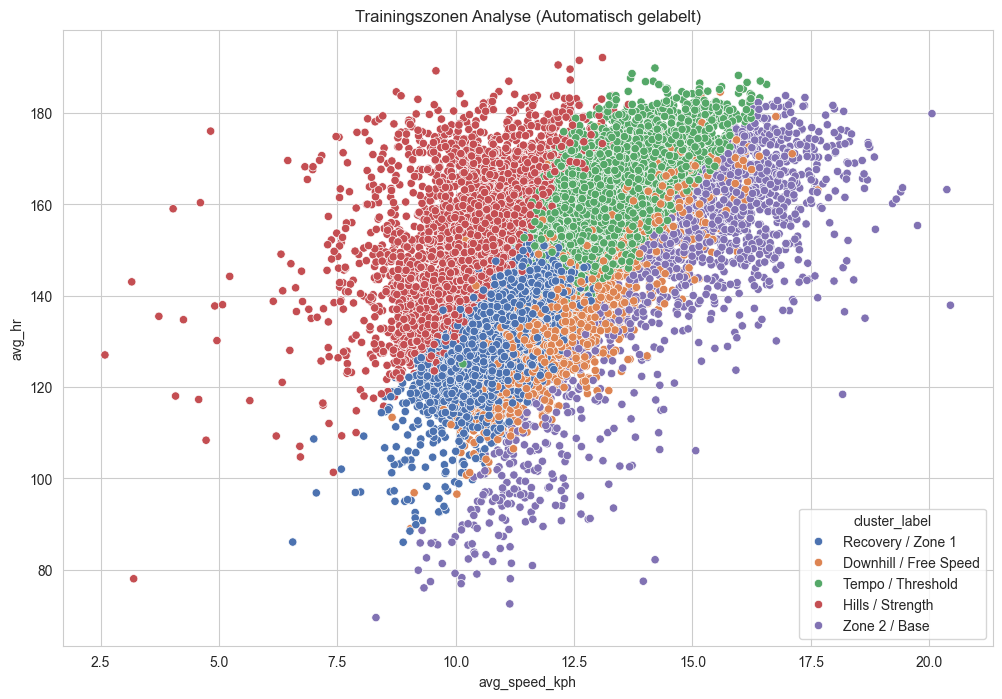

In [380]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_buckets, 
    x='avg_speed_kph', 
    y='avg_hr', 
    hue='cluster_label',  # JETZT benutzen wir den echten Namen!
    palette='deep'
)
plt.title('Trainingszonen Analyse (Automatisch gelabelt)')
plt.show()

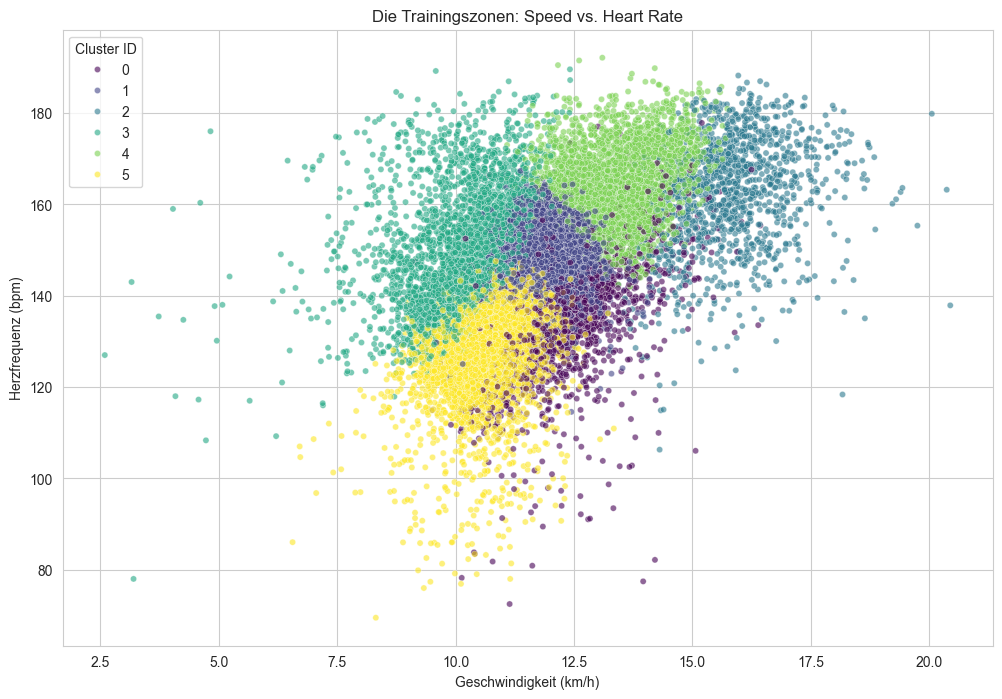

In [355]:
# Design-Setup
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Scatterplot
sns.scatterplot(
    data=df_buckets, 
    x='avg_speed_kph', 
    y='avg_hr', 
    hue='cluster',     # Färbt die Punkte nach Cluster
    palette='viridis', # Gute Farbpalette zur Unterscheidung
    alpha=0.6,         # Transparenz, damit man Overlap sieht
    s=20               # Punktgröße
)

plt.title('Die Trainingszonen: Speed vs. Heart Rate')
plt.xlabel('Geschwindigkeit (km/h)')
plt.ylabel('Herzfrequenz (bpm)')
plt.legend(title='Cluster ID')
plt.show()

# Sanity Check

In [402]:
# Wir suchen uns eine Activity_ID, die viele Datenpunkte hat (langer Lauf)
# Sortieren nach Anzahl der Buckets
top_activities = df_buckets.groupby('activity_id').size().sort_values(ascending=False)
print("Die längsten Läufe (IDs):")
print(top_activities.head(5))

# Wähle hier EINE ID aus der Liste oben aus:
selected_activity_id = top_activities.index[0] # Nimmt automatisch den längsten Lauf
# Oder manuell:
#selected_activity_id = 15098429375

Die längsten Läufe (IDs):
activity_id
14734415622    456
15807829670    421
16041368848    421
15727214067    371
14375594098    323
dtype: int64


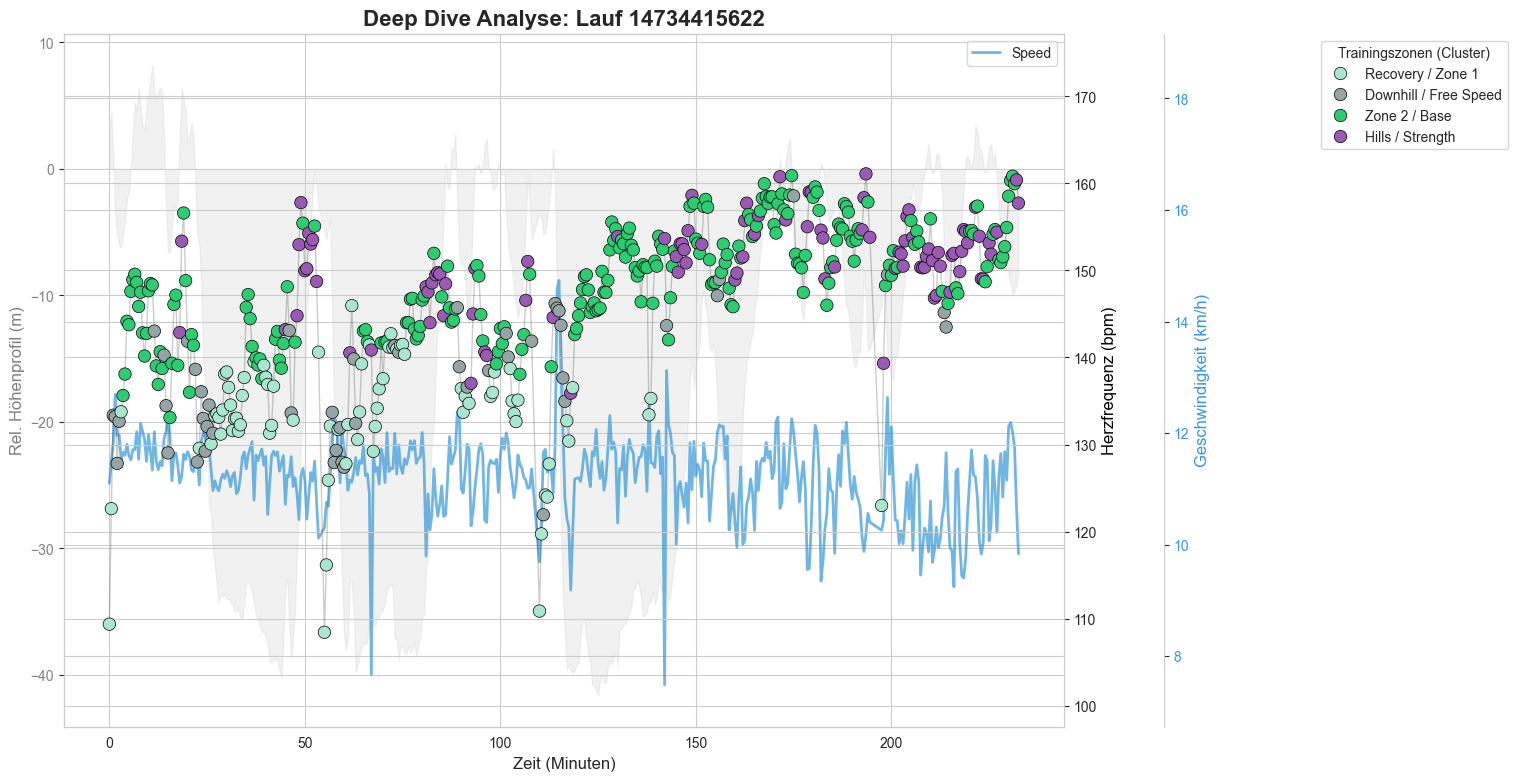

In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- VORBEREITUNG (Wie zuvor) ---
# 1. Daten für diesen einen Lauf filtern
# Stelle sicher, dass 'selected_activity_id' definiert ist!
single_run = df_buckets[df_buckets['activity_id'] == selected_activity_id].copy()
single_run = single_run.sort_values('bucket_index')

# Zeitachse in Minuten
single_run['time_min'] = single_run['bucket_index'] * 0.5
# Kumuliertes Höhenprofil berechnen (für den Hintergrund)
single_run['elevation_profile'] = single_run['elevation_change_m'].cumsum()

# 2. Farben definieren (DEINE LABELS HIER ANPASSEN!)
cluster_colors = {
    'Recovery / Zone 1': '#a8e6cf',     # Hellgrün
    'Zone 2 / Base': '#2ecc71',         # Sattgrün
    'Downhill / Free Speed': '#95a5a6', # Grau
    'Hills / Strength': '#9b59b6',      # Lila
    'Tempo / Threshold': '#e67e22',     # Orange
    'VO2Max / Intervals': '#e74c3c',    # Rot
    'Zone 3 / Fatigue (Junk)': '#c0392b' # Dunkelrot/Braun
}
# Fallback, falls ein Label im Dictionary fehlt
palette = {label: cluster_colors.get(label, 'black') for label in single_run['cluster_label'].unique()}


# --- PLOT START: DAS MULTI-ACHSEN MONSTER ---

# Wir brauchen Platz rechts für die zusätzlichen Achsen
fig, ax_elev = plt.subplots(figsize=(16, 9))
fig.subplots_adjust(right=0.75) # Platz schaffen

# --- ACHSE 1 (Links, Grau): HÖHENPROFIL (Hintergrund) ---
# Wir füllen den Bereich, damit es nicht von den Linien ablenkt
ax_elev.fill_between(single_run['time_min'], single_run['elevation_profile'], 
                     color='lightgrey', alpha=0.3, zorder=1)
ax_elev.set_ylabel('Rel. Höhenprofil (m)', color='grey', fontsize=12)
ax_elev.tick_params(axis='y', labelcolor='grey')
ax_elev.set_xlabel('Zeit (Minuten)', fontsize=12)

# --- ACHSE 2 (Rechts Mitte, Blau): GESCHWINDIGKEIT ---
ax_speed = ax_elev.twinx()
# Wir schieben diese Achse nach rechts außen ('outward'), damit sie nicht überlappt
ax_speed.spines["right"].set_position(("axes", 1.1)) 
sns.lineplot(data=single_run, x='time_min', y='avg_speed_kph', ax=ax_speed, 
             color='#3498db', linewidth=2, alpha=0.7, label='Speed', zorder=5)

ax_speed.set_ylabel('Geschwindigkeit (km/h)', color='#3498db', fontsize=12)
ax_speed.tick_params(axis='y', labelcolor='#3498db')
# Den oberen Teil der Achse etwas freimachen, damit die Punkte Platz haben
ax_speed.set_ylim(bottom=single_run['avg_speed_kph'].min()*0.9, top=single_run['avg_speed_kph'].max()*1.3)


# --- ACHSE 3 (Rechts Innen, Schwarz): HERZFREQUENZ & CLUSTER ---
ax_hr = ax_elev.twinx()
# (Diese Achse ist standardmäßig rechts innen, das passt)

# A) Die feine graue Linie für den Puls-Verlauf
sns.lineplot(data=single_run, x='time_min', y='avg_hr', ax=ax_hr, 
             color='black', alpha=0.2, linewidth=1, zorder=10)

# B) DIE CLUSTER PUNKTE (Das Wichtigste!)
# Wir plotten die Punkte auf der HR-Achse
sns.scatterplot(
    data=single_run, 
    x='time_min', 
    y='avg_hr', 
    hue='cluster_label', 
    palette=palette,
    s=80, edgecolors='black', linewidth=0.5,
    ax=ax_hr, zorder=20
)

ax_hr.set_ylabel('Herzfrequenz (bpm)', color='black', fontsize=12)
# Puls-Achse auch etwas strecken für bessere Sichtbarkeit
ax_hr.set_ylim(bottom=single_run['avg_hr'].min()*0.9, top=single_run['avg_hr'].max()*1.1)


# --- FINISH ---
plt.title(f'Deep Dive Analyse: Lauf {selected_activity_id}', fontsize=16, fontweight='bold')

# Legende für die Cluster nach außen schieben
sns.move_legend(ax_hr, "upper left", bbox_to_anchor=(1.25, 1), title='Trainingszonen (Cluster)')

# Gitterlinien nur für die Hauptachse (HR), sonst wird es unruhig
# ax_hr.grid(True, alpha=0.3)

plt.show()